In [401]:
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
import pandas as pd
from torch.distributions import constraints
from matplotlib import pyplot
from matplotlib.patches import Ellipse
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.5.1')
pyro.enable_validation(True)
pd.set_option('display.max_columns', None)
pyplot.style.use('ggplot')

### Features:
* Extracted genres to identify clusters
* Extracted release periods to identify clusters
* Added Sentiment score on overviews and taglines
* Scaled budget and revenue to millions
* Main features are revenue, budget, popularity, vote_average, runtime, vote_count etc
* Maybe budgets are rounded

In [402]:
FILE_DIR = "../"
tmdb_path = os.path.join(FILE_DIR,"data","the-movies-dataset")
movies_metadata_dir = os.path.join(tmdb_path, "movies_metadata_processed.csv")
movies_metadata = pd.read_csv(movies_metadata_dir)
movies_metadata.head()

,belongs_to_collection,budget,id,original_title,popularity,revenue,runtime,vote_average,vote_count,revenue_mil,budget_mil,drama,comedy,thriller,action,romance,adventure,family,release_2010s,release_2000s,release_1990s,release_1980s_below,overview_vader,tagline_vader
0,0,30000000,862,Toy Story,21.946943,373554033.0,81.0,7.7,5415.0,373.554033,30.0,0,1,0,0,0,0,1,0,0,1,0,0.1280,0.0000
1,1,65000000,8844,Jumanji,17.015539,262797249.0,104.0,6.9,2413.0,262.797249,65.0,0,0,0,0,0,1,1,0,0,1,0,-0.4588,0.5411
2,1,16000000,31357,Waiting to Exhale,3.859495,81452156.0,127.0,6.1,34.0,81.452156,16.0,1,1,0,0,1,0,0,0,0,1,0,0.8860,0.5812
3,1,60000000,949,Heat,17.924927,187436818.0,170.0,7.7,1886.0,187.436818,60.0,1,0,1,1,0,0,0,0,0,1,0,-0.8750,-0.5423
4,1,35000000,9091,Sudden Death,5.231580,64350171.0,106.0,5.5,174.0,64.350171,35.0,0,0,1,1,0,1,0,0,0,1,0,0.5106,-0.5267


In [403]:
fig = px.scatter(movies_metadata, x="budget", y="revenue", hover_name="original_title")
fig.show()

In [404]:
# Normalize by mean and std
def normalize(np_arr):
    return (np_arr - np.mean(np_arr)) / (np.std(np_arr))
movies_metadata['revenue'] = normalize(movies_metadata['revenue'])
movies_metadata['budget'] = normalize(movies_metadata['budget'])
movies_metadata['vote_average'] = normalize(movies_metadata['vote_average'])
movies_metadata['vote_count'] = normalize(movies_metadata['vote_count'])
movies_metadata['popularity'] = normalize(movies_metadata['popularity'])
movies_metadata['runtime'] = normalize(movies_metadata['runtime'])

# Stack features
features = np.stack((
    movies_metadata['budget'], 
    movies_metadata['revenue'],
    #movies_metadata['vote_average']
    #movies_metadata['vote_count'],
    #movies_metadata['popularity'],
    #movies_metadata['runtime'],
    #movies_metadata['overview_vader'],
), axis=1)

# Must be in float32
data = torch.tensor(features, dtype=torch.float32)

# Take subset of data
data = data[:500]

### Experiment 1 (SVI and Normal Inverse Gamma Prior):

For $N$ data points, the likelihood is:
\begin{equation}
    p(x_n | \pi, \mu, \sigma^2) = \sum_{k=1}^{K} \pi_k N(x_n | \mu_k, \sigma_k^2)
\end{equation}

Define prior $\pi \in [0,1]$ such that $\sum_{k=1}^{K} \pi_k = 1$
\begin{equation}
    p(\pi) = Dir(\pi | \alpha \mathbb{1}_K)
\end{equation}

for fixed $\alpha = 1$. Prior for each $\mu_k \in \mathbb{R}^D$
\begin{equation}
    p(\mu_k) = Normal(\mu_k | 0, I)
\end{equation}

Prior for each component $\sigma_k^2 \in \mathbb{R}^D$ to be
\begin{equation}
    p(\sigma_k^2) = InvGamma(\sigma_k^2 | a, b)
\end{equation}

In [405]:
# Number of clusters
K = 8
# Number of dimensions
d = len(features[0])

In [406]:
def model(data):
    """Normal Inverse Gamma Prior"""
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K))) 
    
    with pyro.plate('component', K):
        locs = pyro.sample('locs', dist.MultivariateNormal(torch.zeros(d), 1*torch.eye(d)))        
        scale = pyro.sample('scale', dist.InverseGamma(1, 1))
        
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights))        
        scale_ = scale[assignment].repeat(d, d, 1).transpose(2, 0)
        scale_ *= torch.eye(d).repeat(len(assignment), 1, 1)
        pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scale_), obs=data)
        
global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']))

In [407]:
optim = pyro.optim.Adam({'lr': 0.1})
elbo = TraceEnum_ELBO(max_plate_nesting=1) # This informs Pyro that we use a single plate
svi = SVI(model, global_guide, optim, loss=elbo)

In [408]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    loss = svi.loss(model, global_guide, data)
    return loss

# Randomize, Choose initializations
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, init loss = {}'.format(seed, loss))

/anaconda3/lib/python3.6/site-packages/pyro/util.py:202: UserWarning:

Found vars in model but not guide: {'assignment'}

/anaconda3/lib/python3.6/site-packages/pyro/infer/traceenum_elbo.py:282: UserWarning:

TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.



seed = 24, init loss = 2299.11474609375


In [ ]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(500):
    loss = svi.step(data)
    losses.append(loss)

/anaconda3/lib/python3.6/site-packages/pyro/util.py:202: UserWarning:

Found vars in model but not guide: {'assignment'}

/anaconda3/lib/python3.6/site-packages/pyro/infer/traceenum_elbo.py:282: UserWarning:

TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.



In [ ]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

In [ ]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [ ]:
def plot(data, mus=None, sigmas=None, colors='black', figname='fig.png'):
    """Plot 2D GMMs"""
    fig = pyplot.figure()
    x = data[:, 0]
    y = data[:, 1]
    pyplot.scatter(x, y, 24, c=colors)

    if mus is not None:
        x = [float(m[0]) for m in mus]
        y = [float(m[1]) for m in mus]
        pyplot.scatter(x, y, 99, c='red')

    if sigmas is not None:
        for sig_ix in range(K):
            ax = fig.gca()
            try:
               # For inverse gamma prior
               cov = (torch.eye(d) * sigmas[sig_ix]).detach().numpy()
            except:
               # For LKJ Correlation Cholesky prior
               cov = np.array(sigmas[sig_ix])
            lam, v = np.linalg.eig(cov)
            lam = np.sqrt(lam)
            ell = Ellipse(xy=(x[sig_ix], y[sig_ix]),
                          width=lam[0]*4, height=lam[1]*4,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          color='blue')
            ell.set_facecolor('none')
            ax.add_artist(ell)

In [ ]:
# Get MAP Estimates
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
plot(data, locs, scale)

In [ ]:
# Reference: https://nbviewer.jupyter.org/github/jiangzl2016/prob_prog_final_project/blob/master/final-project/final-notebook.ipynb
# Plot clusters, not components
for i in range(len(locs)):
    pyplot.figure(figsize=(6, 2))
    for j in range(len(locs[0])):
        X = np.arange(-10, 10, 0.01)
        pyplot.title('cluster'+str(i))
        pyplot.xlabel('x')
        pyplot.ylabel('Density')
        pyplot.plot(X, weights[i].item() * scipy.stats.norm.pdf(X,locs[i][j].item(), scale[i].item()))
pyplot.show()


### Experiment 2: NUTS and Normal-LKJ Correlation Cholesky Prior

Problem:
* Clusters tend to converge together.
* Not fully probabilistic - Inverse Gamma prior for variance does not capture cross-covariances.

Alternative:
* For multivariate covariance matrix, one possible conjugate prior is the Inverse-Wishart distribution [Gelmen et al., Bayesian Data Analysis]
* However, the Inverse Wishart is not a suitable prior in practice. Firstly, This is because the positive-definite and symmetric constraints the probability of generating a valid sample by varying each element is almost zero; meaning it is difficult to sample from these objects. 
* Secondly, the Wishart distribution is heavy-tailed which causes problems for samplers. Heavy tails are obstructions to ergodicity which is a requirement for MCMC. When tails of the target distribution are heavy, the sampler drifts around in the tails and difficult to return back to heavy mass. Computational cost is a concern too.

Solution:
* MCMC for full posterior over components.
* Use the LKJ Correlation Cholesky Prior.
* Better tails and pairs with MCMC.
* Cholesky factors for computation.

Resources:
* https://docs.pymc.io/notebooks/LKJ.html
* https://dahtah.wordpress.com/2012/08/22/priors-of-convenience/
* https://docs.pymc.io/notebooks/LKJ.html

Equation:

LKJ distribution provides prior on correlation matrix $C=Corr(x_{i}, x_{k})$.

By combining priors on $\sigma$ of each component, this induces a prior on the covariance matrix.

Inverting $\Sigma$ is numerically unstable and inefficient.

This inversion takes $\mathcal{O}(N^3)$.

Consider the cholesky decomposition s.t. $\Sigma= L L^T$.

$L$ is the lower-triangular matrix, which allows the computation of $(x-\mu)^T \Sigma^{-1} (x-\mu)$ using back substitution, which is more numerically stable.

\begin{align}
\theta &\sim HalfCauchy(2.5) \\
L_\omega &\sim LKJCorrCholesky(\eta =2 ) \\
L_\Omega &\sim diag(\sqrt{\theta}) \times \omega
\end{align} 


In [343]:
def model(data):
    """
    LKJ Correlation Cholesky prior for full probabilistic covariance
    
    Pyro Documentation: 
    When using LKJ with NUTS, it is important to use a step_size such 
    as 1e-4. If not, you are likely to experience LAPACK errors 
    regarding positive-definiteness.
    """
    weights = pyro.sample('weights', dist.Dirichlet(0.5*torch.ones(K)))
    # Vector of variances for each of the d variables
    # hack: to_event(1) fixes tensor shapes
    theta = pyro.sample("theta", dist.HalfCauchy(torch.ones(d)).to_event(1)) 
    # Lower cholesky factor of a correlation matrix
    eta = torch.ones(1)
    # Lower cholesky factor of the covariance matrix
    L_omega = pyro.sample("L_omega", dist.LKJCorrCholesky(d, eta))
    L_Omega = torch.mm(torch.diag(theta.sqrt()), L_omega)
    
    with pyro.plate('components', K):
        mu = pyro.sample('locs', dist.MultivariateNormal(torch.zeros(d), 1*torch.eye(d)))
        
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample("obs", dist.MultivariateNormal(mu[assignment], scale_tril=L_Omega), obs=data)
        
global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'L_omega']))

In [344]:
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4) # Use this for LJK
mcmc = MCMC(kernel, num_samples=250, warmup_steps=50)
mcmc.run(data)
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 300/300 [01:59,  2.51it/s, step size=1.45e-01, acc. prob=0.873]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



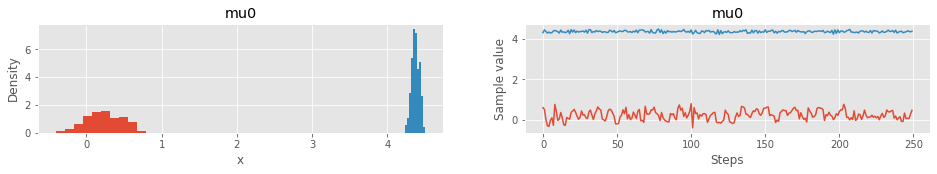

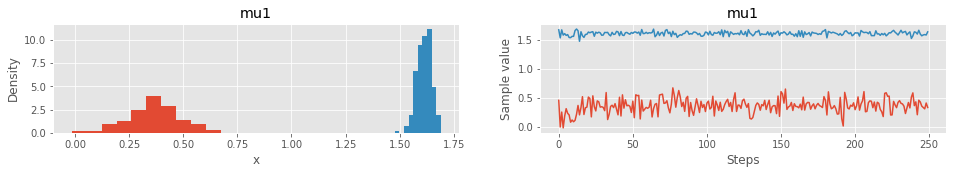

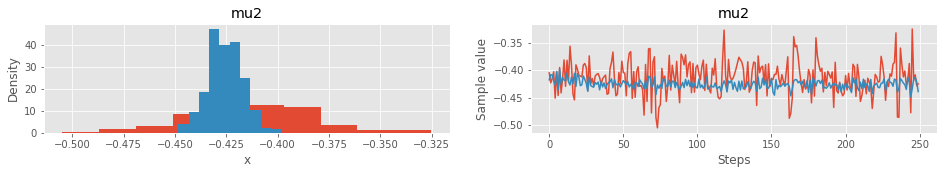

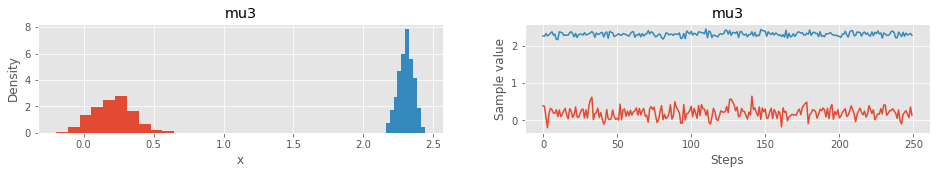

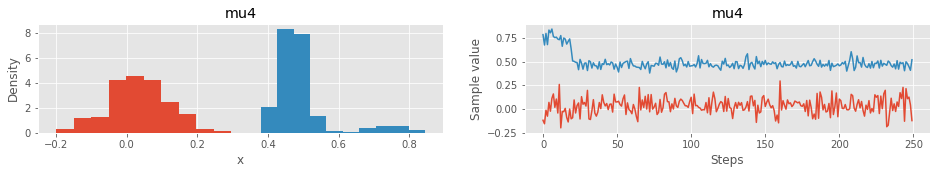

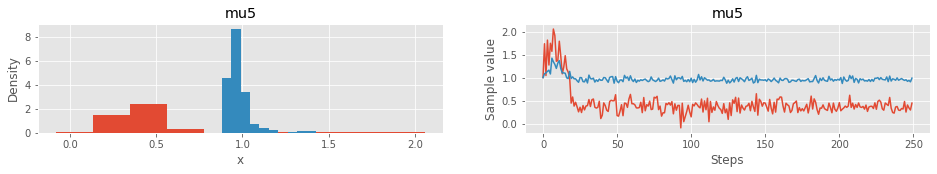

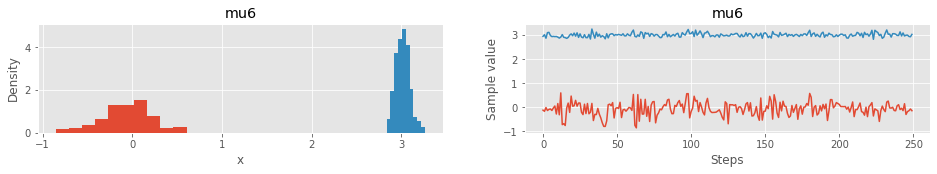

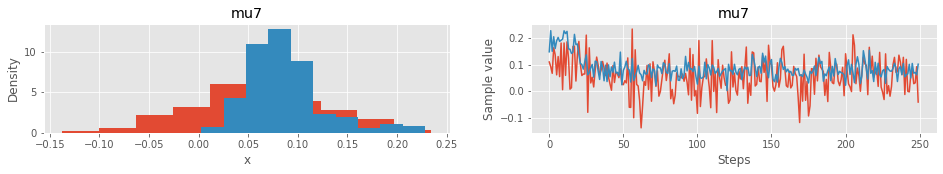

In [399]:
# Plot trace
# Tensor shape is ([N, K, d])
for i in range(K):
    # Trace of each cluster
    trace = posterior_samples["locs"][:,i,:]
    pyplot.figure(figsize=(16,2))
    for j in range(d):
        pyplot.subplot(1, 2, 1)
        pyplot.title('mu'+str(i))
        pyplot.ylabel('Density')
        pyplot.xlabel('x')
        pyplot.hist(trace[:,j],normed=True)
        pyplot.subplot(1, 2, 2)
        pyplot.title('mu'+str(i))
        pyplot.ylabel('Sample value')
        pyplot.xlabel('Steps')
        pyplot.plot((trace[:,j]))
    
    #trace = posterior_samples["locs"].transpose(2,0)[i]
    #print(len(trace))
    #pyplot.figure()
    #for j in range(len(trace)):
        #pyplot.figure()
    #    pyplot.subplot(1, 2, 1)
    #    pyplot.hist(trace[j])
    #    pyplot.subplot(1, 2, 2)
    #    pyplot.plot((trace[j]))


#posterior_samples["locs"][:,0,:]
        

In [400]:
L

#L = torch.mm(torch.diag(posterior_samples["theta"][0].sqrt()), posterior_samples["L_omega"][0])
#cov_single = torch.mm(L,L.t())
#cov = [cov_single, cov_single, cov_single]
#mu = [posterior_samples["locs"][0][0].tolist(), 
#      posterior_samples["locs"][0][1].tolist(),
#      posterior_samples["locs"][0][2].tolist()]
#plot(data, mu, cov)

tensor([[0.5597, 0.0000],
        [0.1975, 0.3373]])

In [203]:
posterior_samples["locs"].transpose(2,0)[:,0]

tensor([[[ 0.2115,  0.2549,  0.0324,  ...,  0.0224,  0.1088,  0.0942],
         [ 1.3229,  0.2840,  0.8825,  ..., -0.4152,  0.7595,  0.7143],
         [-0.1744, -0.1776, -0.2500,  ..., -0.2084, -0.2200, -0.2101]],

        [[ 2.3832,  2.3729,  2.2269,  ...,  2.2671,  2.4981,  2.4775],
         [-1.5158, -0.5974, -1.9672,  ..., -1.2891, -1.2602, -1.2103],
         [-0.1379, -0.1200, -0.1847,  ..., -0.1366, -0.1339, -0.1191]],

        [[ 7.0605,  6.8501,  7.0169,  ...,  7.4004,  7.3055,  7.1897],
         [-0.2717, -0.1059, -0.2067,  ...,  0.0793, -0.8468, -0.8167],
         [ 6.6245,  6.6791,  6.6346,  ...,  6.7001,  6.6268,  6.6951]]])

In [215]:
#cluster_one = []
#cluster_two = []
#cluster_three = []
#for i in range(len(posterior_samples["locs"])):
#    sample = posterior_samples["locs"][i]
#    cluster_one.append(sample[0])
#    cluster_two.append(sample[1])
#    cluster_three.append(sample[2])

In [216]:
# Plot trace and posterior of NUTS
# Transpose doesn't work for more than 2 clusters
#cluster_one = posterior_samples["locs"].transpose(2,0)[0]
#cluster_two = posterior_samples["locs"].transpose(2,0)[1]
#cluster_three = posterior_samples["locs"].transpose(2,0)[2]

In [82]:
#pyplot.title('Trace of cluster 1')
#pyplot.plot(cluster_one[0], color='red')
#pyplot.plot(cluster_one[1], color='blue')
#pyplot.show()
#pyplot.title('Trace of cluster 2')
#pyplot.plot(cluster_two[0], color='red')
#pyplot.plot(cluster_two[1], color='blue')
#pyplot.show()
#mcmc_locs = [[torch.mean(cluster_one[0]), torch.mean(cluster_one[1])], 
#             [torch.mean(cluster_two[0]), torch.mean(cluster_two[1])]]
#mcmc_scale = scale
#plot(data, mcmc_locs, mcmc_scale)